# 1-2 图片数据建模流程

## 一、准备数据
cifar2数据集为cifar10数据集的子集, 只包括前两种类别airplane和automobile

训练集有airplane和automobile图片各5000张, 测试集有airplane和automobile图片各1000张

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集文件结构如下所示：
![](./data/cifar2.jpg)

Pytorch中构建图片数据管道通常有三种方式
* 第一种是使用torchvision中的datasets.ImageFolder来读取图片, 然后用DataLoader来进行加载

* 第二种是通过继承torch.utils.data.Dataset实现用户自定义读取逻辑, 然后用DataLoader来进行加载

* 第三种是读取用户自定义数据集的通用方法, 既可以读取图片数据集, 也可以读取文本数据集

在这里我们介绍第一种方法。

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [4]:
# 加如transform
transform_train = transforms.Compose([transforms.ToTensor()])

transform_valid = transforms.Compose([transforms.ToTensor()])

In [5]:
ds_train = datasets.ImageFolder("./data/cifar2/train/", transform=transform_train, target_transform=lambda t: torch.tensor([t]).float())

ds_valid = datasets.ImageFolder("./data/cifar2/test/", transform=transform_valid, target_transform=lambda t: torch.tensor([t]).float())

print(ds_train.class_to_idx)  # 这个属性是来自于父类DatasetFolder, 这个可以从源码中看到

{'0_airplane': 0, '1_automobile': 1}


In [8]:
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True, num_workers=3)
dl_valid = DataLoader(ds_valid, batch_size=10, shuffle=True, num_workers=3)

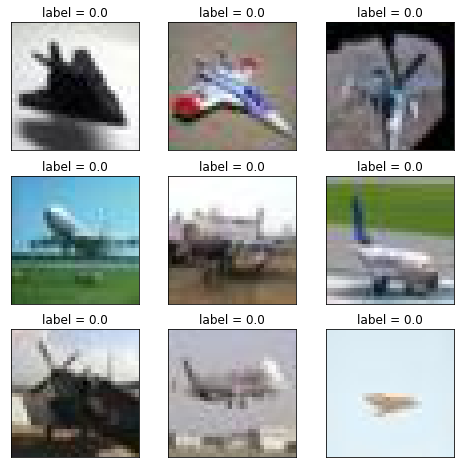

In [9]:
# 查看部分样本
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 8))

for i in range(9):
    img, label = ds_train[i]
    img = img.permute(1, 2, 0)  # 这个tensorflow的transpose一样, pytorch读取的时候通道数在最前面
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = {}".format(label.item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [10]:
# pytorch的图片默认顺序是Batch, Channel, Width, Height

for x, y in dl_train:
    print(x.shape, y.shape)
    break

torch.Size([10, 3, 32, 32]) torch.Size([10, 1])


## 二、定义模型
使用Pytorch通常有三种方式构建模型, 前面已经讲了, 这里不再赘述。

此处选择通过继承nn.Module基类构建自定义模型

In [11]:
# 测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1, 1))
t = torch.randn(10, 8, 32, 32)
pool(t).shape

torch.Size([10, 8, 1, 1])

In [12]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.dropout = nn.Dropout(0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [13]:
import torchkeras
torchkeras.summary(net, input_shape=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
           Dropout-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
            Linear-9                    [-1, 1]              33
          Sigmoid-10                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forward/backward pass size (MB): 0.359390
Params size (MB): 0.207035
E

## 三、训练模型
Pytorch通常需要用户自定义编写训练循环, 训练循环的代码大致有三类。这里使用函数形式训练循环。

In [23]:
import pandas as pd
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred, y_true: roc_auc_score(y_true.data.numpy(), y_pred.data.numpy())
model.metric_name = "auc"

In [29]:
def train_step(model, features, labels):
    # 调整为训练模式
    model.train()

    # 梯度清除
    model.optimizer.zero_grad()

    # 正向传播
    pred = model(features)
    loss = model.loss_func(pred, labels)
    # metric = model.metric_func(pred, labels), 这里直接用metric会有bug

    # 反向传播球梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(), 0

def valid_step(model, features, labels):
    # 预测模式
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        pred = model(features)
        loss = model.loss_func(pred, labels)
        # metric = model.metric_func(pred, labels), 这里直接用metric会有bug
    return loss.item(), 0

# 测试train_step效果
features, labels = next(iter(dl_train))
train_step(model, features, labels)

(0.36176443099975586, 0)

In [32]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns=["epochs", "loss", metric_name, "val_loss", "val_"+metric_name])
    print("Start Training")
    
    for epoch in range(1, epochs+1):
        # 1.训练循环
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):
            loss, metric = train_step(model, features, labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:
                print("[step = {}] loss = {:.3f}, {}: {:.3f}".format(step, loss_sum/step, metric_name, metric_sum/step))
        
        # 2.验证循环
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features, labels) in enumerate(dl_valid, 1):
            val_loss, val_metric = valid_step(model, features, labels)
            val_loss_sum += val_loss
            val_metric_sum += val_metric
        # 3.记录日志
        info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info
        
    # 打印epoch级别日志
    print("\nEPOCH = {:d}, loss = {:.3f} {} = {:.3f}, val_loss = {:.3f}, val_{}, = {:.3f}".format(*info[:2], metric_name, *info[2:4], metric_name, info[-1]))
    print("Finished Training")
    return dfhistory

In [33]:
epochs = 2
dfhistory = train_model(model, epochs, dl_train, dl_valid, log_step_freq=50)

Start Training
[step = 50] loss = 0.424, auc: 0.000
[step = 100] loss = 0.443, auc: 0.000
[step = 150] loss = 0.425, auc: 0.000
[step = 200] loss = 0.423, auc: 0.000
[step = 250] loss = 0.427, auc: 0.000
[step = 300] loss = 0.426, auc: 0.000
[step = 350] loss = 0.420, auc: 0.000
[step = 400] loss = 0.417, auc: 0.000
[step = 450] loss = 0.412, auc: 0.000
[step = 500] loss = 0.413, auc: 0.000
[step = 550] loss = 0.413, auc: 0.000
[step = 600] loss = 0.411, auc: 0.000
[step = 650] loss = 0.412, auc: 0.000
[step = 700] loss = 0.410, auc: 0.000
[step = 750] loss = 0.409, auc: 0.000
[step = 800] loss = 0.409, auc: 0.000
[step = 850] loss = 0.406, auc: 0.000
[step = 900] loss = 0.404, auc: 0.000
[step = 950] loss = 0.404, auc: 0.000
[step = 1000] loss = 0.402, auc: 0.000
[step = 50] loss = 0.336, auc: 0.000
[step = 100] loss = 0.345, auc: 0.000
[step = 150] loss = 0.355, auc: 0.000
[step = 200] loss = 0.353, auc: 0.000
[step = 250] loss = 0.357, auc: 0.000
[step = 300] loss = 0.357, auc: 0.00

## 四、使用模型

In [38]:
def predict_single_img(model, img):
    model.eval()
    with torch.no_grad():
        result = model(img)
        print("pred:", result)

In [39]:
img, label = ds_train[1]
img = torch.unsqueeze(img, 0)  # 添加batchdim
predict_single_img(model, img)
print("true label:", label)

pred: tensor([[0.2021]])
true label: tensor([0.])
